In [1]:
# This file is from Jordan
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

In [2]:
sp_ratings = pd.read_excel('./dataset/labels.xlsx', sheet_name='sp-ratings')
label2rating = {
    0: 'AAA',
    1: 'AA+',
    2: 'AA',
    3: 'AA-',
    4: 'A+',
    5: 'A',
    6: 'A-',
    7: 'BBB+',
    8: 'BBB',
    9: 'BBB-',
    10: 'BB+',
    11: 'BB',
    12: 'BB-',
    13: 'B+',
    14: 'B',
    15: 'B-',
    16: 'CCC+',
    17: 'CCC',
    18: 'CCC-',
    19: 'CC',
    20: 'C',
    21: 'D',
}

# rating2label = {
#     'AAA': 1,
#     'AA+': 2,
#     'AA': 2,
#     'AA-': 2,
#     'A+': 3,
#     'A': 3,
#     'A-': 3,
#     'BBB+': 4,
#     'BBB': 4,
#     'BBB-': 4,
#     'BB+': 5,
#     'BB': 5,
#     'BB-': 5,
#     'B+': 6,
#     'B': 6,
#     'B-': 6,
#     'CCC+': 7,
#     'CCC': 7,
#     'CCC-': 7,
#     'CC': 7,
#     'C': 7,
#     'D': 7,
#     'SD': 7,
# }

# rating2label = {
#     'AAA': 1,
#     'AA+': 1,
#     'AA': 1,
#     'AA-': 1,
#     'A+': 1,
#     'A': 1,
#     'A-': 1,
#     'BBB+': 1,
#     'BBB': 1,
#     'BBB-': 1,
#     'BB+': 0,
#     'BB': 0,
#     'BB-': 0,
#     'B+': 0,
#     'B': 0,
#     'B-': 0,
#     'CCC+': 0,
#     'CCC': 0,
#     'CCC-': 0,
#     'CC': 0,
#     'C': 0,
#     'D': 0,
#     'SD': 0,
# }

rating2label = dict((v,k) for k,v in label2rating.items())
rating2label['SD'] = 21

q4_ratings = sp_ratings[['2014Q4', '2015Q4', '2016Q4']]
q4_labels = q4_ratings.replace(rating2label)
# print(q4_labels)
# label is 1, 2, 3
# print(q4_ratings)
# rating is A, B, C
# print(q4_labels[~q4_labels['2015Q4'].isin(label2rating.keys())])

q4_labels[~q4_labels['2015Q4'].isin(label2rating.keys())]

df_14q4 = pd.read_csv('./dataset/2014Q4.csv')
df_14q4 = df_14q4.fillna(df_14q4.mean()) # fill missing values with mean
df_15q4 = pd.read_csv('./dataset/2015Q4.csv').fillna(0)
df_15q4 = df_15q4.fillna(df_15q4.mean())
df_16q4 = pd.read_csv('./dataset/2016Q4.csv').fillna(0)
df_16q4 = df_16q4.fillna(df_16q4.mean())

X = pd.concat([df_14q4, df_15q4, df_16q4], ignore_index=True)
y = q4_labels.melt(value_name='Target Label').drop('variable', axis=1)
# print(q4_labels)
# print(q4_labels.melt(value_name='Target Label'))
# print(y)
X=(X-X.mean())/X.std() # feature scaling
df = pd.concat([X, y], axis=1)


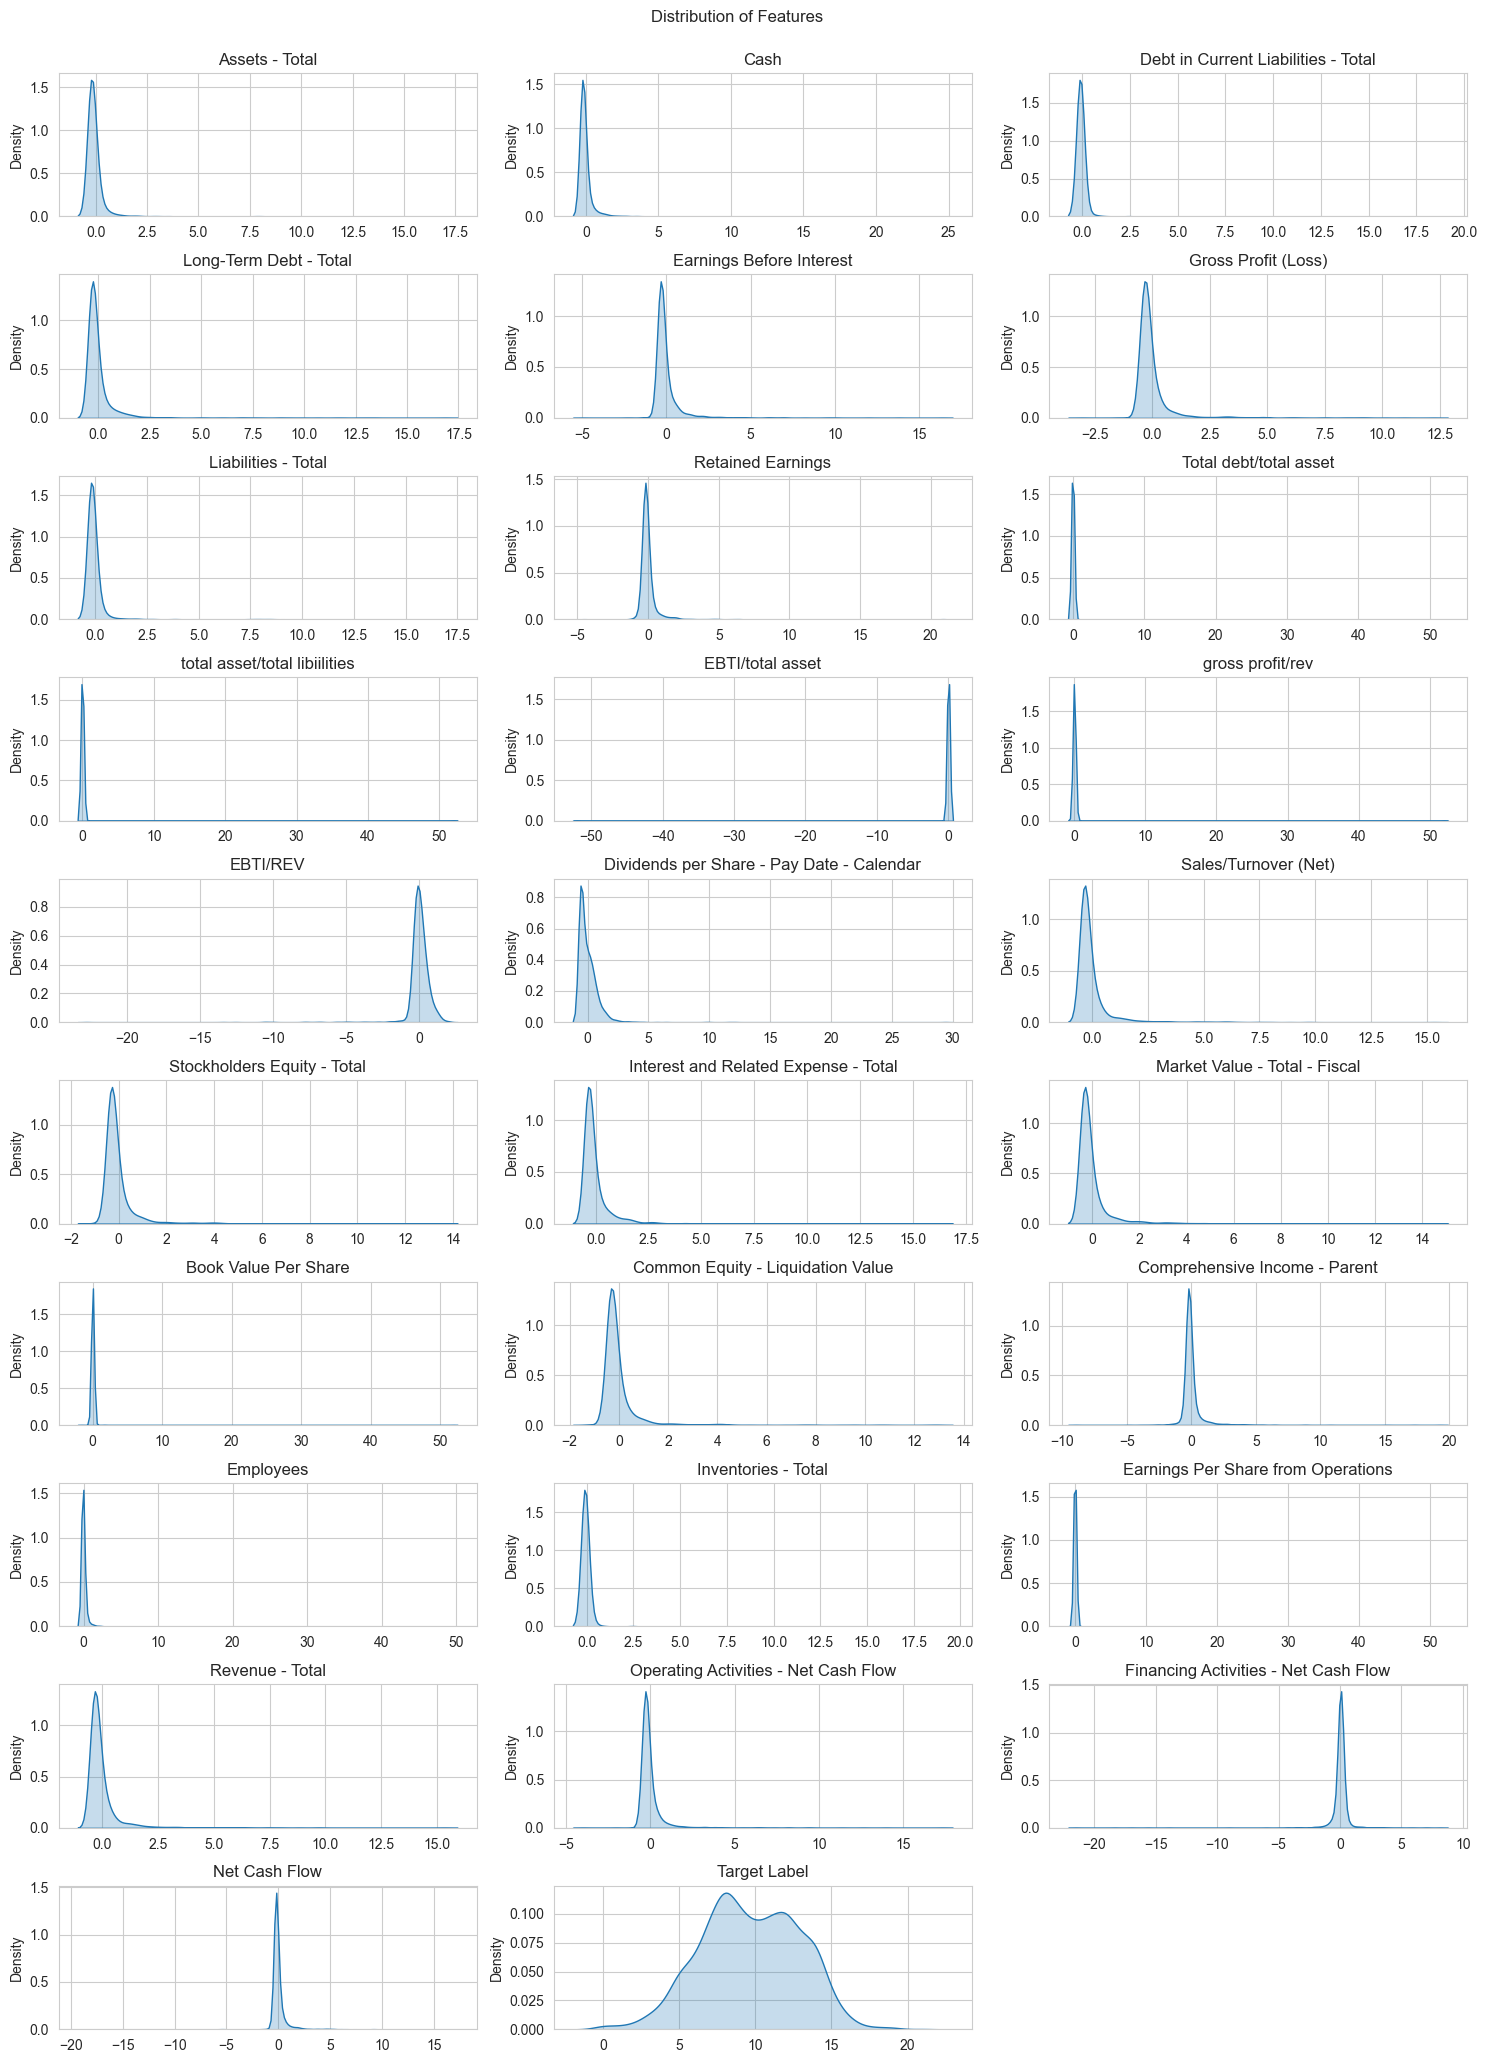

In [3]:
import seaborn as sns

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 21), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D
cols = df.columns[:]  # create a list of dataframe columns to use

for col, ax in zip(cols, axes):
    # data = df[col]  # select the data
    sns.kdeplot(data=df, x=col, fill=True, ax=ax)
    ax.set(title=f'{col}', xlabel=None)
    
fig.delaxes(axes[29])  # delete the empty subplot
fig.suptitle('Distribution of Features')
fig.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

C:\Users\Shuyao\AppData\Local\Temp\ipykernel_20076\2550634518.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar.set_xticklabels(bar.get_xticklabels(), rotation=90);


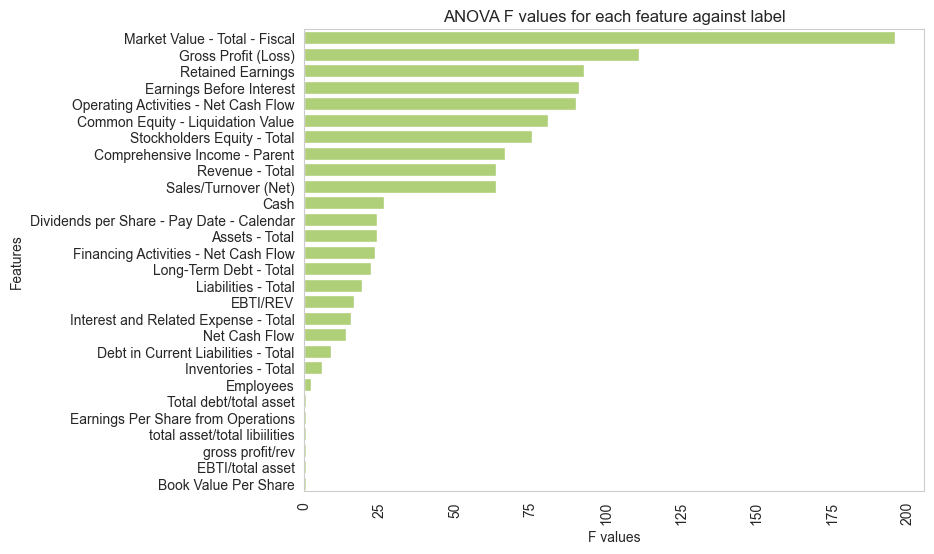

In [14]:
from sklearn.feature_selection import f_classif

import matplotlib.cm as cm
select = (0.1, 0.5, 0.3)
cmap = cm.Set3
colors = cmap(np.linspace(0.5, 1, 1))

scores = f_classif(X, y['Target Label']) # performing ANOVA for the features against the target

df_scores = pd.DataFrame({'features': X.columns.to_list(), 'ANOVA_f_values': scores[0]}).sort_values(by=['ANOVA_f_values'], ascending=False)
plt.figure(figsize=(8,6))
bar = sns.barplot(y='features', x='ANOVA_f_values', data=df_scores, color=colors)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90);
bar.set_xlabel('F values');
bar.set_ylabel('Features');
bar.set_title('ANOVA F values for each feature against label');

plt.grid(False)
#print(df_scores)

Text(0.5, 1.03, 'Lowest correlation features')

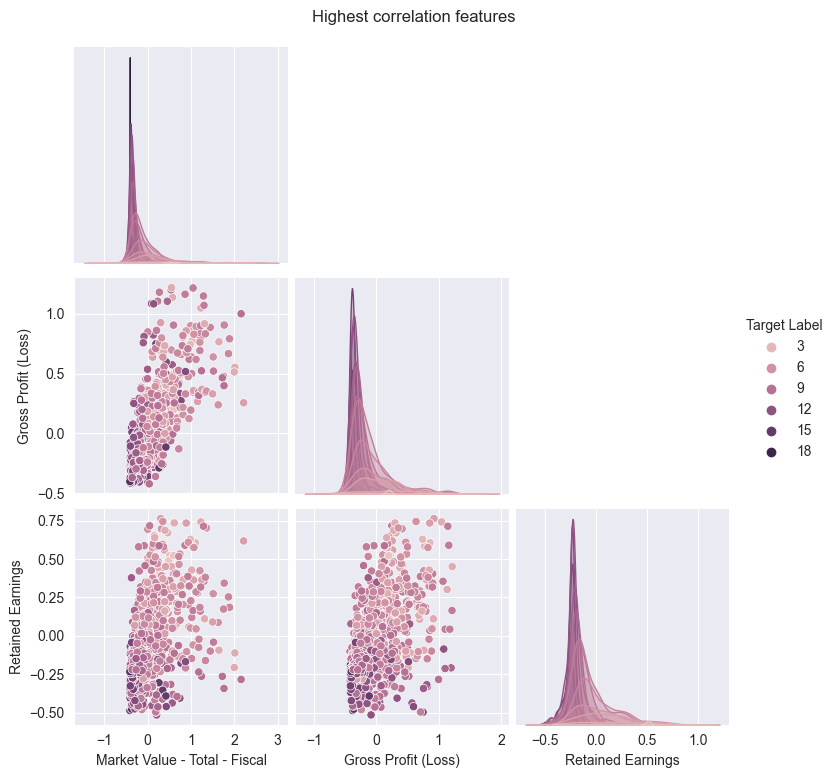

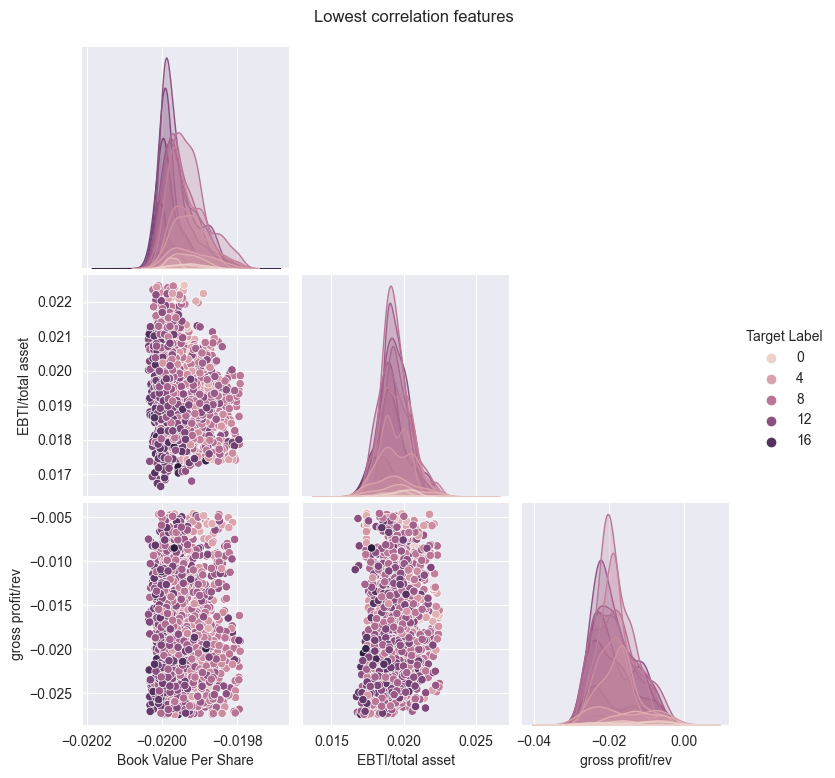

In [26]:
high_f = df[['Market Value - Total - Fiscal', 'Gross Profit (Loss)', 'Retained Earnings', 'Target Label']]
for col in high_f.columns.to_list()[:-1]:
    high_f = high_f[
        (high_f[col] < np.quantile(high_f[col], 0.975)) &
        (high_f[col] > np.quantile(high_f[col], .025))]

g = sns.pairplot(high_f, hue='Target Label', corner=True)
g.fig.suptitle('Highest correlation features', y=1.03)

low_f = df[['Book Value Per Share', 'EBTI/total asset', 'gross profit/rev', 'Target Label']]
for col in low_f.columns[:-1]:
    low_f = low_f[
        (low_f[col] < np.quantile(low_f[col], 0.975)) &
        (low_f[col] > np.quantile(low_f[col], .025))]

g = sns.pairplot(low_f, hue='Target Label', corner=True)
g.fig.suptitle('Lowest correlation features', y=1.03)

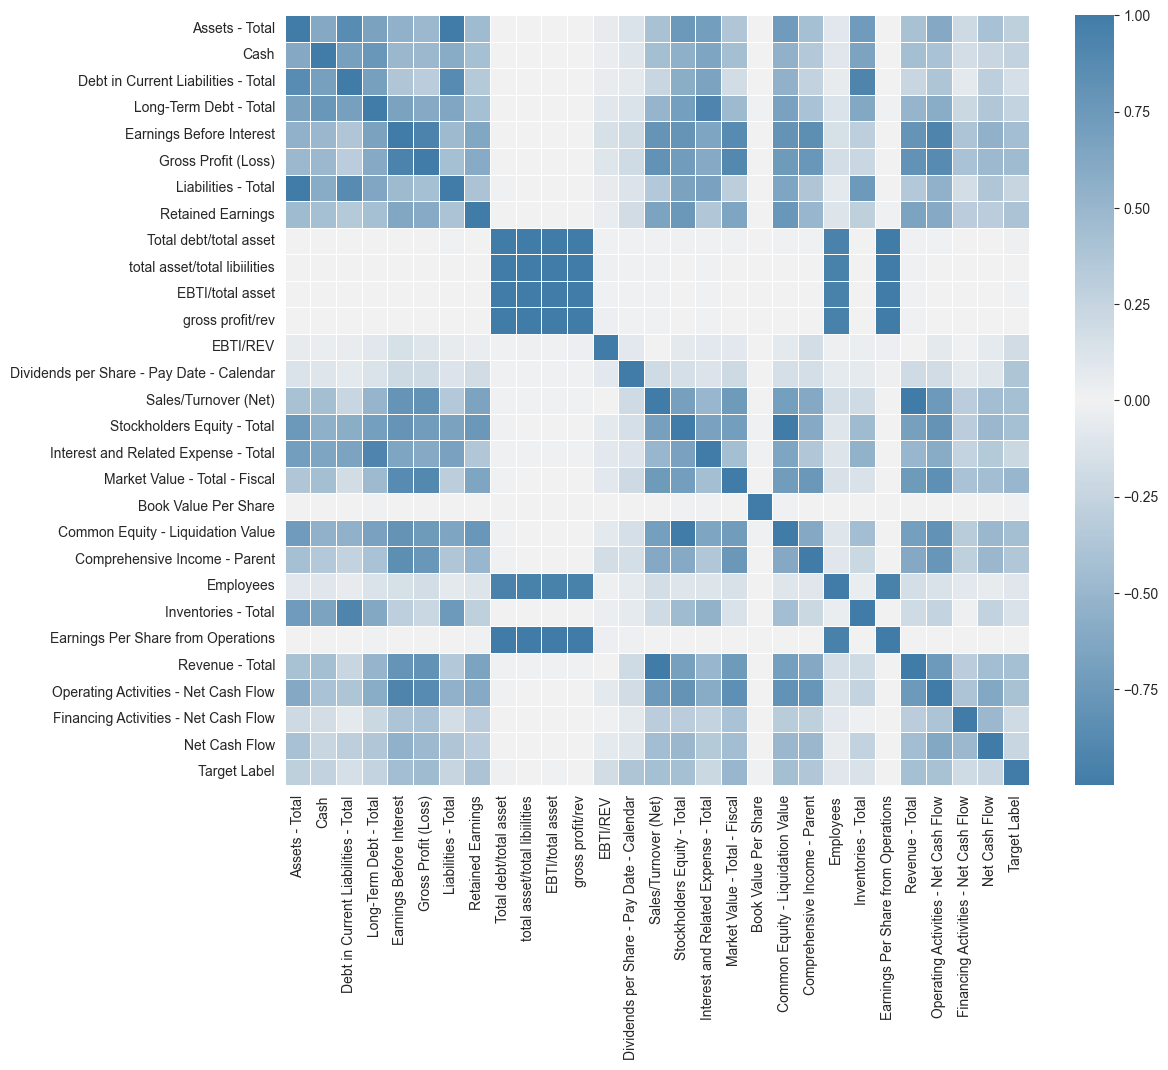

In [27]:
plt.figure(figsize=(12,10))
cor = df.corr(method='pearson')
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(cor, annot=False, fmt='.1f', linewidth=0.4,
            annot_kws={"size": 10}, cmap=cmap)
plt.show()
# cor_target = abs(cor["TARGET"])
# relevant_features = cor_target[cor_target>0.1]
# relevant_features